# Final Project
Tugasmu adalah untuk membangun sebuah model yang mampu melakukan valuasi dari harga tanah dan rumah menggunakan teknik-teknik yang sudah diajarkan selama pelatihan program 3.

Kamu diberikan 2 data:
- `data/train_sample.csv`

    Gunakan data ini untuk kebutuhan membangun model
- `data/test_sample.csv`

  Gunakan data ini untuk kebutuhan submission. Data hanya mengandung fitur ($X$) saja, dan tugasmu adalah untuk submit prediksi ($\hat{y}$) menggunakan fitur tersebut

Kolom `price` adalah kolom target yang ingin diprediksi, dan berikut nomenklatur kolom-kolom fiturnya:
- `sold_date`: Tanggal properti terakhir dijual
- `sold_price`: Harga properti terakhir dijual
- `year_built`: Tahun properti tersebut dibangun
- `garage`: Kapasitas garasi (jumlah mobil)
- `sqft`: Luas rumah (dalam $ft^2$)
- `type`: Tipe properti (single-family home, condo, dll)
- `transport`: Ketersediaan akses ke transportasi umum
- `services`: Survey kepuasan penyewa (1 sampai 5)
- `beds`: Jumlah tempat tidur
- `floors`: Jumlah lantai
- `baths`: Jumlah kamar mandi
- `lot_sqft`: Luas tanah (dalam $ft^2$)

## Import Library yang dibutuhkan

In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import RobustScaler, OneHotEncoder
from sklearn.metrics import mean_absolute_error, r2_score, root_mean_squared_error

## Load Data

In [38]:
df = pd.read_csv('data/train_sample.csv')
df.head()

,sold_date,sold_price,year_built,garage,sqft,type,price,transport,services,beds,floors,baths,lot_sqft
0,2005-05-16,46.480370,1966.0,1.0,320.000000,condos,45.503842,False,5,2.0,31.0,1.0,NaN
1,NaN,NaN,2013.0,1.0,NaN,condos,66.400062,False,2,2.0,16.0,2.0,NaN
2,2005-06-17,59.103574,1935.0,2.0,644.000000,single_family,120.926742,True,5,4.0,2.0,3.0,1599.0
3,NaN,NaN,1922.0,NaN,NaN,condos,48.237728,False,2,2.0,3.0,2.0,NaN
4,2000-03-13,11.283478,1961.0,NaN,266.666667,condos,27.813441,False,5,1.0,8.0,1.0,NaN


In [39]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1600 entries, 0 to 1599
Data columns (total 13 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   sold_date   1136 non-null   object 
 1   sold_price  1136 non-null   float64
 2   year_built  1433 non-null   float64
 3   garage      1023 non-null   float64
 4   sqft        1150 non-null   float64
 5   type        1600 non-null   object 
 6   price       1594 non-null   float64
 7   transport   1600 non-null   bool   
 8   services    1600 non-null   int64  
 9   beds        1550 non-null   float64
 10  floors      1303 non-null   float64
 11  baths       1599 non-null   float64
 12  lot_sqft    792 non-null    float64
dtypes: bool(1), float64(9), int64(1), object(2)
memory usage: 151.7+ KB


In [40]:
df.describe()

,sold_price,year_built,garage,sqft,price,services,beds,floors,baths,lot_sqft
count,1136.000000,1433.000000,1023.000000,1150.000000,1594.000000,1600.000000,1550.000000,1303.000000,1599.000000,792.000000
mean,66.321839,1943.490579,2.160313,693.690145,111.498879,3.178750,3.294194,7.185725,2.442777,2511.638468
std,104.167345,39.403958,12.515107,588.244993,232.552532,1.501069,1.769450,13.083246,1.491006,25515.203842
min,0.649330,1853.000000,1.000000,151.333333,0.071187,1.000000,0.000000,1.000000,0.000000,0.333333
25%,20.358466,1913.000000,1.000000,385.916667,40.916142,2.000000,2.000000,2.000000,2.000000,1041.666667
50%,40.562374,1941.000000,2.000000,515.666667,63.647552,2.000000,3.000000,2.000000,2.000000,1250.000000
75%,72.750024,1968.000000,2.000000,769.166667,104.594288,5.000000,4.000000,4.000000,3.000000,1666.750000
max,1254.561061,2021.000000,400.000000,8333.333333,4272.739470,5.000000,21.000000,119.000000,13.000000,718666.666667


## Cleansing

### Drop data yang tidak berlabel

In [120]:
# Menghapus Data null di kolom target (price
df = df.dropna(subset=['price'])
df['price'].isnull().sum()

np.int64(0)

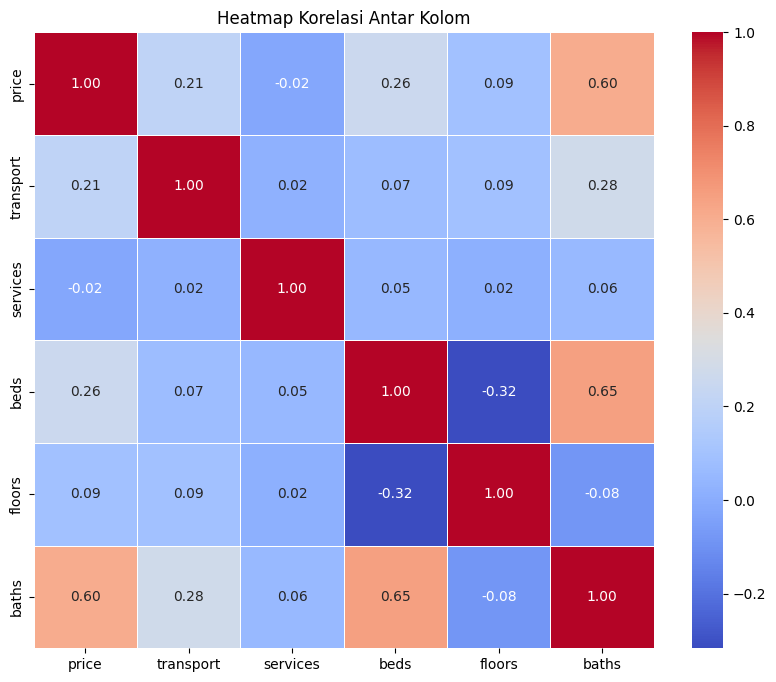

In [121]:
# Memvisualisasikan korelasi antar kolom dengan heatmap
# Hitung korelasi antar kolom numerik
corr_matrix = df.corr(numeric_only=True)

# Buat heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Heatmap Korelasi Antar Kolom')
plt.show()

In [122]:
# mengecek nilai null di semua kolom
df.isnull().sum()

type           0
price          0
transport      0
services       0
beds          49
floors       294
baths          1
dtype: int64

In [123]:
df.columns

Index(['type', 'price', 'transport', 'services', 'beds', 'floors', 'baths'], dtype='object')

In [124]:
# menghapus kolom yang memiliki nilai null banyak
df = df.drop(columns=['sold_date', 'sold_price', 'year_built', 'garage', 'sqft','lot_sqft'])
df

KeyError: "['sold_date', 'sold_price', 'year_built', 'garage', 'sqft', 'lot_sqft'] not found in axis"

In [ ]:
# Memilih kolom yang diperlukan dan berpengaruh terhadap target
df_clean = df[['baths','transport','type','price']]
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1594 entries, 0 to 1599
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   baths      1593 non-null   float64
 1   transport  1594 non-null   bool   
 2   type       1594 non-null   object 
 3   price      1594 non-null   float64
 4   services   1594 non-null   int64  
dtypes: bool(1), float64(2), int64(1), object(1)
memory usage: 63.8+ KB


In [ ]:
df_clean.reset_index(drop=True, inplace=True)

In [ ]:
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1594 entries, 0 to 1599
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   baths      1593 non-null   float64
 1   transport  1594 non-null   bool   
 2   type       1594 non-null   object 
 3   price      1594 non-null   float64
 4   services   1594 non-null   int64  
dtypes: bool(1), float64(2), int64(1), object(1)
memory usage: 63.8+ KB


In [ ]:
df_clean.isnull().sum()

baths        1
transport    0
type         0
price        0
services     0
dtype: int64

### Visualisasi Outlier

<Axes: xlabel='price', ylabel='type'>

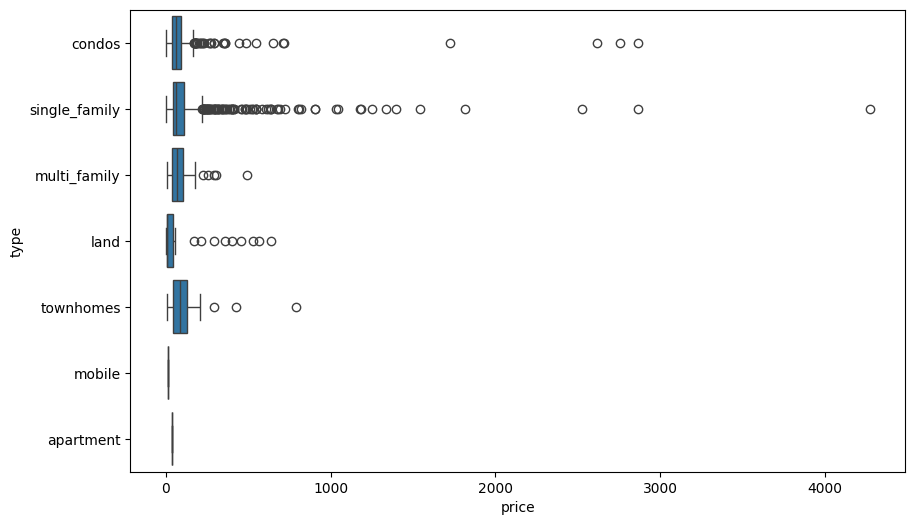

In [ ]:
# menampilkan boxplot price berdasarkan type
plt.figure(figsize=(10, 6))
sns.boxplot(x='price', y='type', data=df_clean) 

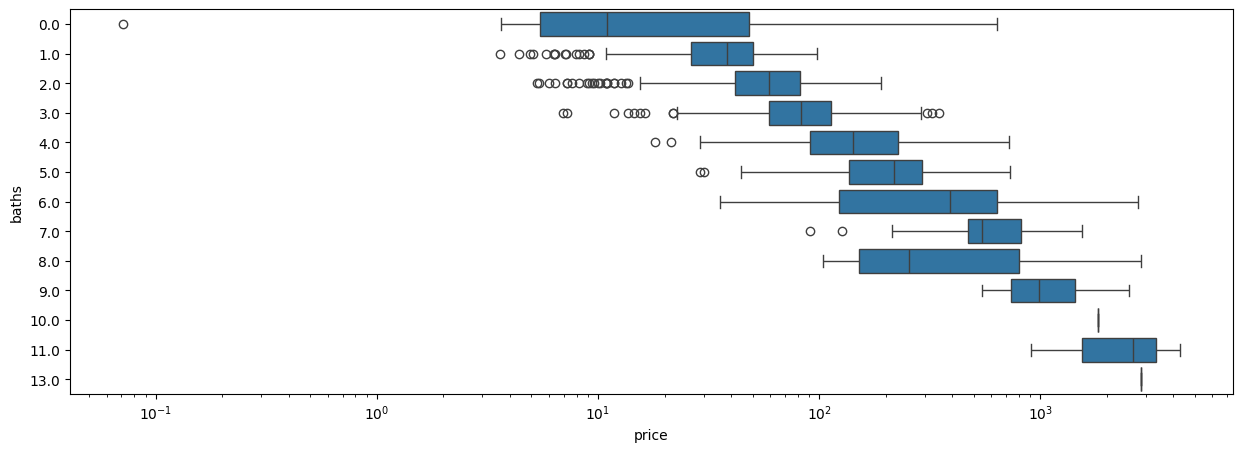

In [ ]:
# menampilkan boxplot price berdasarkan batchs
plt.figure(figsize=(15, 5))
sns.boxplot(df_clean, x="price", y="baths", orient="h", log_scale=(True, False));

In [ ]:
df_clean['baths'].value_counts()

baths
2.0     666
3.0     325
1.0     296
4.0     130
0.0      52
5.0      51
6.0      35
7.0      16
8.0      13
9.0       4
11.0      3
13.0      1
10.0      1
Name: count, dtype: int64

In [ ]:
outliers_baths_0 = df_clean[df_clean['baths'] == 0]
outliers_baths_0 = outliers_baths_0.sort_values(by='price')
outliers_baths_0.head()


,baths,transport,type,price,services
814,0.0,True,land,0.071187,2
1124,0.0,False,land,3.632060,2
464,0.0,False,land,3.658463,2
322,0.0,False,land,3.929048,2
47,0.0,False,land,4.526995,2


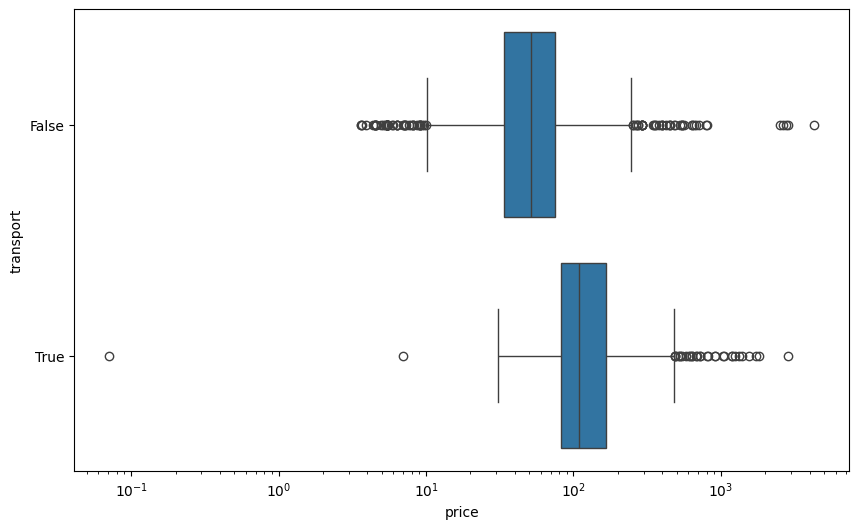

In [ ]:
# menampilkan boxplot price berdasarkan transport
plt.figure(figsize=(10, 6))
sns.boxplot(df_clean, x="price", y="transport", orient="h", log_scale=(True, False));

Karena dilihat terdapat 1 outlier yang memiliki harga rumah sangat kecil dan berada jauh dari rentang, tetapi tidak dihapus dalam data ini karena mungkin itu memang harga asli rumah tersebut.

# Dataset Splitting
- Gunakan 20% data sebagai data uji
- Gunakan `random_state` untuk pengacakan yang terkontrol

In [125]:
X = df_clean.drop(columns="price")
y = df_clean.price

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=42)
X_train.shape, X_test.shape

((1275, 4), (319, 4))

### Preprocessing pipeline

In [126]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, OneHotEncoder

In [127]:
# pipeline preprocessing untuk kolom numeric
numeric_pipeline = Pipeline([
    ("impute", SimpleImputer(strategy='median')),
    ("scale", RobustScaler()),
])
numeric_pipeline

,steps,"[('impute', ...), ('scale', ...)]"
,transform_input,None
,memory,None
,verbose,False
,missing_values,nan
,strategy,'median'
,fill_value,None
,copy,True
,add_indicator,False
,keep_empty_features,False
,with_centering,True


In [128]:
# pipeline preprocessing untuk kolom kategorik
categoric_pipeline = Pipeline([
    ("impute", SimpleImputer(strategy='most_frequent')),
    ("encode", OneHotEncoder(drop="first", handle_unknown="ignore"))
])
categoric_pipeline

,steps,"[('impute', ...), ('encode', ...)]"
,transform_input,None
,memory,None
,verbose,False
,missing_values,nan
,strategy,'most_frequent'
,fill_value,None
,copy,True
,add_indicator,False
,keep_empty_features,False
,categories,'auto'


In [129]:
# menggabungkan pipeline preprocessing untuk kolom numerik dan kategorik
preprocessor = ColumnTransformer([
    ("numeric", numeric_pipeline, ["baths"]),
    ("categoric", categoric_pipeline, ["type", "transport"])
])
preprocessor

,transformers,"[('numeric', ...), ('categoric', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True
,force_int_remainder_cols,'deprecated'
,missing_values,nan
,strategy,'median'
,fill_value,None


# Training
- Model Ridge regression
- Menggunakan Pipeline

In [117]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV

In [133]:
pipeline = Pipeline([
    ("prep", preprocessor),
    ("algo", Ridge())
])
param_grid = {
    "algo__alpha": [0.01, 0.1, 1, 10, 100],
    "algo__fit_intercept": [True, False]
}
model = GridSearchCV(pipeline, param_grid, cv=5, n_jobs=-1, verbose=1)
model.fit(X_train, y_train)



modelBest= model.best_estimator_
model.best_params_

Fitting 5 folds for each of 10 candidates, totalling 50 fits


{'algo__alpha': 10, 'algo__fit_intercept': True}

In [134]:
pipeline 

,steps,"[('prep', ...), ('algo', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('numeric', ...), ('categoric', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


# Evaluasi

### Perhitungan Metrik
- Hitung prediksi di masing-masing data train dan data test
- Hitung metrik R2, MAE, dan RMSE untuk masing-masing data train dan data test

In [136]:
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

In [135]:
pred_train = modelBest.predict(X_train)
pred_test = modelBest.predict(X_test)

In [137]:
# TRAIN
r2_train = r2_score(y_train, pred_train)
mae_train = mean_absolute_error(y_train, pred_train)
rmse_train = np.sqrt(mean_squared_error(y_train, pred_train))

# TEST
r2_test = r2_score(y_test, pred_test)
mae_test = mean_absolute_error(y_test, pred_test)
rmse_test = np.sqrt(mean_squared_error(y_test, pred_test))

In [138]:
print("Train Evaluation")
print(f"R2  : {r2_train:.3f}")
print(f"MAE : {mae_train:.3f}")
print(f"RMSE: {rmse_train:.3f}")

print("\nTest Evaluation")
print(f"R2  : {r2_test:.3f}")
print(f"MAE : {mae_test:.3f}")
print(f"RMSE: {rmse_test:.3f}")

Train Evaluation
R2  : 0.440
MAE : 87.047
RMSE: 187.025

Test Evaluation
R2  : 0.349
MAE : 74.398
RMSE: 114.537


### Actual vs Prediction Plot

In [139]:
from sklearn.metrics import PredictionErrorDisplay

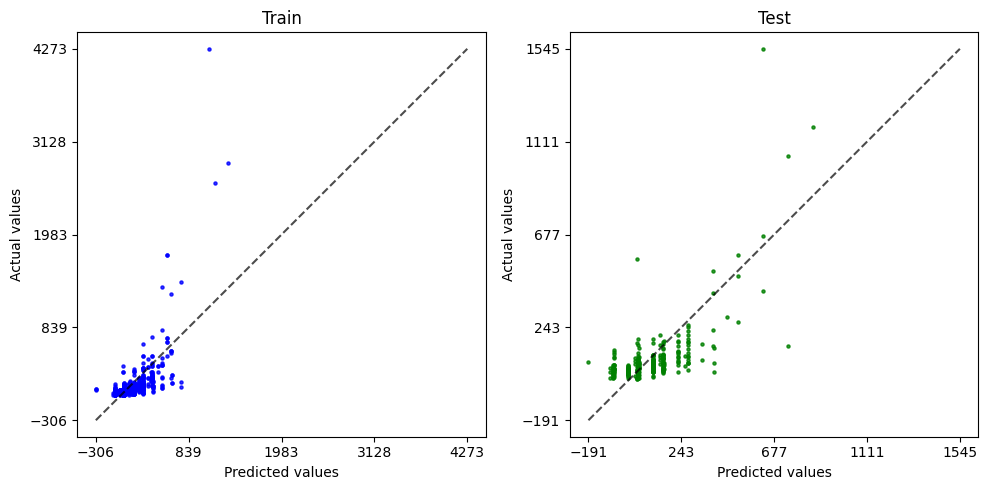

In [140]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
PredictionErrorDisplay.from_estimator(model, X_train, y_train, kind="actual_vs_predicted", scatter_kwargs={"c": "b", "s": 5}, ax=ax[0])
ax[0].set_title("Train")
ax[0].set_aspect("equal")

PredictionErrorDisplay.from_estimator(model, X_test, y_test, kind="actual_vs_predicted", scatter_kwargs={"c": "g", "s": 5}, ax=ax[1])
ax[1].set_title("Test")
ax[1].set_aspect("equal")

fig.tight_layout()

# Submit Prediksimu ke LMS

In [141]:
df_submit = pd.read_csv("data/test_sample.csv")

In [142]:
pd.DataFrame(modelBest.predict(df_submit)).to_csv('my_submission.csv')

```
Program ini diadakan oleh Komdigi, Yandex, Digitalent, dan Techready.

